In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 150

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset = torchvision.datasets.MNIST('./MNIST_DATA2',
               transform=torchvision.transforms.ToTensor(),
               download=True)

In [4]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./MNIST_DATA2
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
indices = dataset.targets == 7

dataset.data, dataset.targets = dataset.data[indices], dataset.targets[indices]


In [6]:
train_set, val_set = torch.utils.data.random_split(dataset,[5265, 1000])

In [7]:
mean_image = torch.mean(torch.Tensor.float(train_set.dataset.data), dim=0) / 255.

In [8]:
mean_norm_image = mean_image/mean_image.sum()


In [9]:
mean_norm_image.sum()

tensor(1.0000)

In [10]:
import pickle

In [11]:
#with open(r"vae_mnist_v2.pickle", "wb") as output_file:
#    pickle.dump(mean_norm_image.numpy(), output_file)

In [12]:
with open(r"vae_mnist_v2.pickle", "rb") as input_file:
    mean_norm_image = pickle.load(input_file)

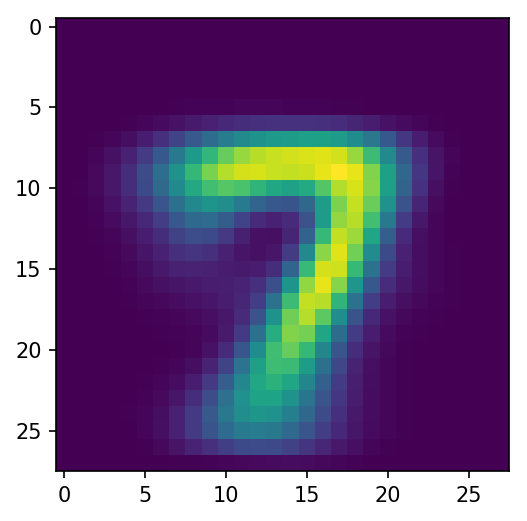

In [13]:
plt.imshow(mean_norm_image)

In [13]:
val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=128,
        shuffle=True)

In [14]:
train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=128,
        shuffle=True)

In [15]:
for i,x in enumerate(val_loader):
    if i < 1:
        print(x[0])

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [18]:
#testdataset = torchvision.datasets.MNIST('./MNIST_DATA',
#                   transform=torchvision.transforms.ToTensor(),
#                   train=False,
#                   download=False)

In [19]:
#test_loader = torch.utils.data.DataLoader(
#        testdataset,
#        batch_size=1000,
#        shuffle=True)

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 24)
        self.bn1     = nn.BatchNorm1d(24)
        self.linear2 = nn.Linear(24,  48)
        self.bn2     = nn.BatchNorm1d(48)
        self.linear3 = nn.Linear(48, 784)

    def forward(self, z):
        z = F.relu(self.bn1(self.linear1(z)))
        z = F.relu(self.bn2(self.linear2(z)))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 28, 28))



In [15]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 48)
        self.bn1     = nn.BatchNorm1d(48)
        self.linear2 = nn.Linear(48,  24)
        self.bn2     = nn.BatchNorm1d(24)
    
        self.linear_mu = nn.Linear(24, latent_dims)
        self.linear_std = nn.Linear(24, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        #print(x.size())
        x = F.relu(self.bn1(self.linear1(x)))
        x = F.relu(self.bn2(self.linear2(x)))
        mu =  self.linear_mu(x)
        sigma = torch.exp(self.linear_std(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [16]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [17]:
def validate(autoencoder, valdata):
    val_loss = 0
    with torch.no_grad():
        for x,y in valdata:
            x = x.to(device)
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            val_loss += loss
    
    return val_loss

In [18]:
def train(autoencoder, data, epochs=1000):
    opt = torch.optim.Adam(autoencoder.parameters(),lr=1e-3)
    patience = 0
    min_loss = 9999999999.9
    patience = 0
    for epoch in range(epochs):
                
        for x, y in train_loader:
            x = x.to(device) # GPU
            #print(x)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            #print(loss)
            loss.backward()
            opt.step()
        val_loss = validate(autoencoder, val_loader)
        if val_loss < min_loss:
            patience = 0
            print(val_loss)
            torch.save(vae.state_dict(), "./MNIST_VAE_validated_v2.h5")
            min_loss = val_loss
        else:
            patience += 1
            print(val_loss, f"patience limit {patience}")
            if patience > 10:
                print("patience limit exceeded, exiciting")
                break
    return autoencoder


In [19]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
#vae = train(vae, train_loader)


In [20]:
vae.load_state_dict(torch.load("./MNIST_VAE_validated_v2.h5"))

<All keys matched successfully>

In [21]:
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=48, bias=True)
    (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=48, out_features=24, bias=True)
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_mu): Linear(in_features=24, out_features=2, bias=True)
    (linear_std): Linear(in_features=24, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=24, bias=True)
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=24, out_features=48, bias=True)
    (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=48, out_features=784, bias=True)
  )
)

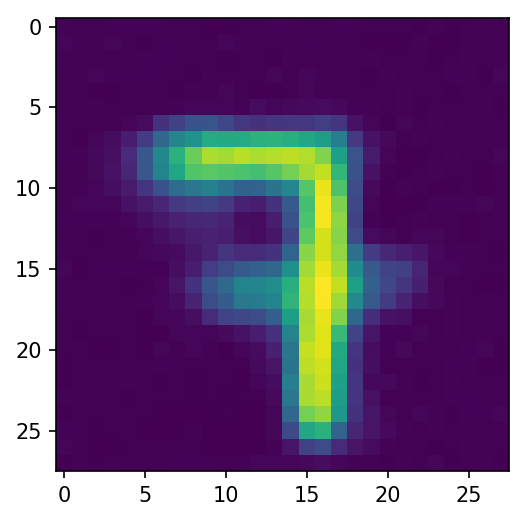

In [74]:
for i, (x,y) in enumerate(test_loader):
    if i>0:
        break
    x.to(device)
    #print(vae(x[0].to(device)).view(28,28).size())
    #plt.imshow(x[3].view(28,28))
    #print(x[7].view(28,28))
    plt.imshow(vae(x[40].view(1,28,28).to(device)).cpu().detach().view(28,28))

In [35]:
testdataset = torchvision.datasets.MNIST('./MNIST_DATA',
                   transform=torchvision.transforms.ToTensor(),
                   train=False,
                   download=False)

In [36]:
indices = testdataset.targets == 5

testdataset.data, testdataset.targets = testdataset.data[indices], testdataset.targets[indices]

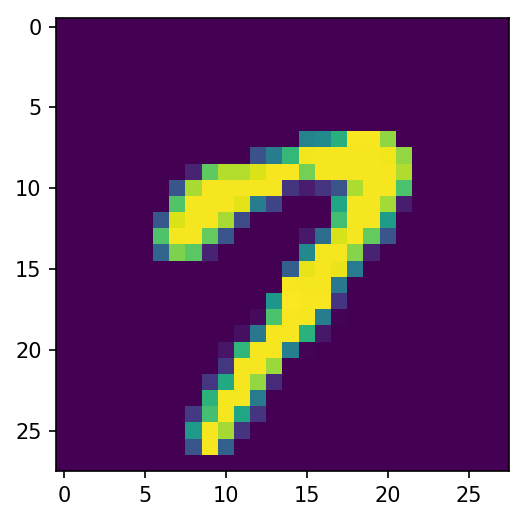

In [60]:
plt.imshow(dataset.data[0])

In [38]:
test_loader = torch.utils.data.DataLoader(
        testdataset,
        batch_size=1000,
        shuffle=False)

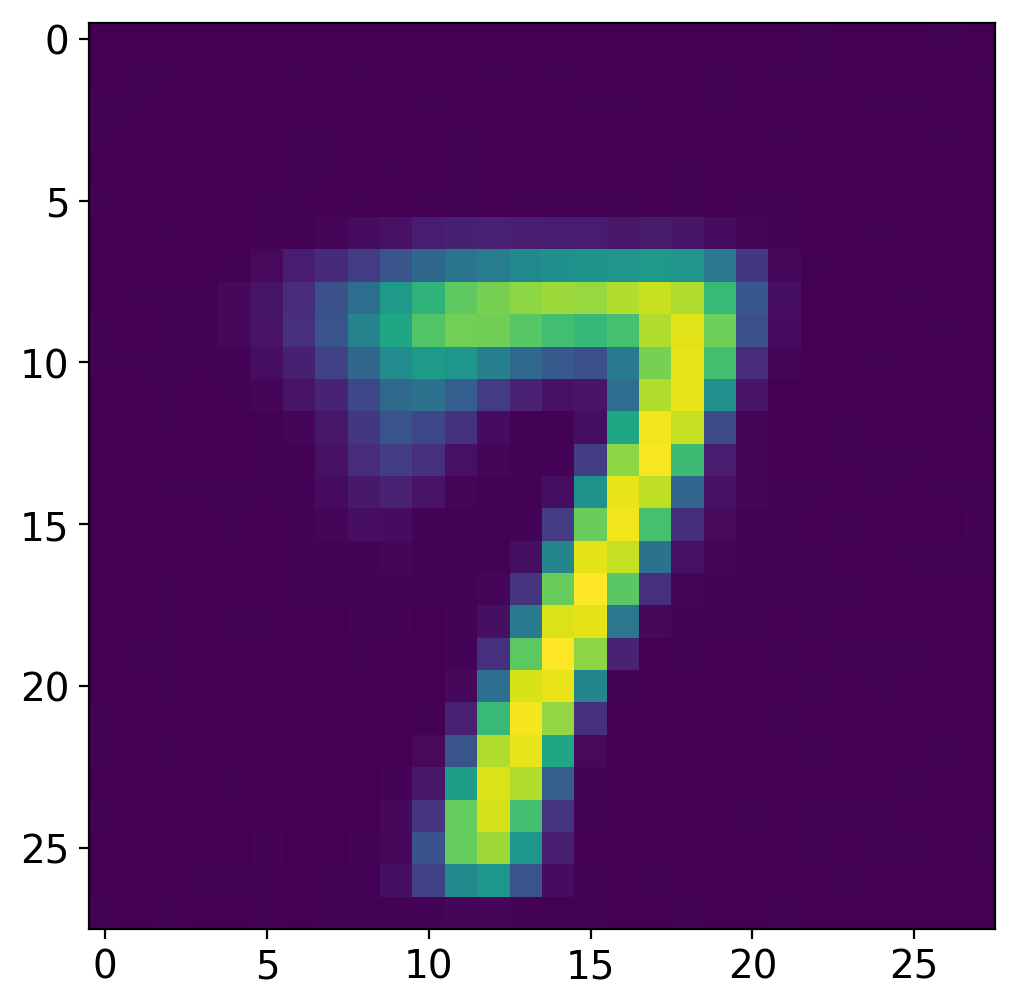

In [164]:
for i, (x,y) in enumerate(test_loader):
    if i>0:
        break
    x.to(device)
    #print(vae(x[0].to(device)).view(28,28).size())
    #plt.imshow(x[3].view(28,28))
    #print(x[7].view(28,28))
    plt.imshow(vae(x[10].to(device)).cpu().detach().view(28,28))

In [22]:
#wasserstein_list = np.array([])
loss_list = np.array([])
for i, (x,y) in enumerate(test_loader):

    VAE_loss = torch.mean((vae(x.to(device)).view(-1,784)- x.to(device).view(-1,784))**2,dim=1).data.cpu().numpy()
    print(VAE_loss.shape)
    loss_list = np.append(loss_list,VAE_loss)

NameError: name 'test_loader' is not defined

In [34]:
loss_list.shape

(892,)

In [77]:
from geomloss import SamplesLoss

loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

In [79]:
from scipy.stats import wasserstein_distance

In [80]:
from scipy.stats import pearsonr

In [41]:
test_loader = torch.utils.data.DataLoader(
        testdataset,
        batch_size=1,
        shuffle=False)

In [47]:
wasserstein_list = np.array([])
wasserstein_scipy_list = np.array([])
for i, (x,y) in enumerate(test_loader):
    print(i)
    #print(vae(x[0].to(device)).view(28,28).size())
    #print(x[0].to(device).view(28,28).size())
    #vfunc = np.vectorize(loss,signature='(i,j,k),(j,k)->(i)')
    #print(x.to(device).view(28,28).size())
    #print(mean_image.size())
    #print(loss(x.view(28,28).to(device),mean_image.to(device)).data.cpu().numpy())
    norm_img = x/x.sum()
    print(norm_img.sum(), norm_img.size())
    #wasserstein_list = np.append(wasserstein_list,loss(x.view(28,28).to(device),mean_image.to(device)).data.cpu().numpy())
    #wasserstein_scipy_list = np.append(wasserstein_scipy_list,wasserstein_distance(x.view(784).data.cpu().numpy(),mean_image.view(784).data.cpu().numpy()))
    #print(x[0])
    #print(mean_image)

0
tensor(1.0000) torch.Size([1, 1, 28, 28])
1
tensor(1.) torch.Size([1, 1, 28, 28])
2
tensor(1.0000) torch.Size([1, 1, 28, 28])
3
tensor(1.) torch.Size([1, 1, 28, 28])
4
tensor(1.0000) torch.Size([1, 1, 28, 28])
5
tensor(1.0000) torch.Size([1, 1, 28, 28])
6
tensor(1.) torch.Size([1, 1, 28, 28])
7
tensor(1.0000) torch.Size([1, 1, 28, 28])
8
tensor(1.) torch.Size([1, 1, 28, 28])
9
tensor(1.0000) torch.Size([1, 1, 28, 28])
10
tensor(1.0000) torch.Size([1, 1, 28, 28])
11
tensor(1.) torch.Size([1, 1, 28, 28])
12
tensor(1.) torch.Size([1, 1, 28, 28])
13
tensor(1.0000) torch.Size([1, 1, 28, 28])
14
tensor(1.0000) torch.Size([1, 1, 28, 28])
15
tensor(1.0000) torch.Size([1, 1, 28, 28])
16
tensor(1.) torch.Size([1, 1, 28, 28])
17
tensor(1.) torch.Size([1, 1, 28, 28])
18
tensor(1.) torch.Size([1, 1, 28, 28])
19
tensor(1.) torch.Size([1, 1, 28, 28])
20
tensor(1.0000) torch.Size([1, 1, 28, 28])
21
tensor(1.) torch.Size([1, 1, 28, 28])
22
tensor(1.0000) torch.Size([1, 1, 28, 28])
23
tensor(1.0000) t

465
tensor(1.0000) torch.Size([1, 1, 28, 28])
466
tensor(1.0000) torch.Size([1, 1, 28, 28])
467
tensor(1.) torch.Size([1, 1, 28, 28])
468
tensor(1.) torch.Size([1, 1, 28, 28])
469
tensor(1.) torch.Size([1, 1, 28, 28])
470
tensor(1.) torch.Size([1, 1, 28, 28])
471
tensor(1.0000) torch.Size([1, 1, 28, 28])
472
tensor(1.) torch.Size([1, 1, 28, 28])
473
tensor(1.) torch.Size([1, 1, 28, 28])
474
tensor(1.0000) torch.Size([1, 1, 28, 28])
475
tensor(1.0000) torch.Size([1, 1, 28, 28])
476
tensor(1.) torch.Size([1, 1, 28, 28])
477
tensor(1.) torch.Size([1, 1, 28, 28])
478
tensor(1.0000) torch.Size([1, 1, 28, 28])
479
tensor(1.) torch.Size([1, 1, 28, 28])
480
tensor(1.) torch.Size([1, 1, 28, 28])
481
tensor(1.0000) torch.Size([1, 1, 28, 28])
482
tensor(1.0000) torch.Size([1, 1, 28, 28])
483
tensor(1.) torch.Size([1, 1, 28, 28])
484
tensor(1.0000) torch.Size([1, 1, 28, 28])
485
tensor(1.) torch.Size([1, 1, 28, 28])
486
tensor(1.0000) torch.Size([1, 1, 28, 28])
487
tensor(1.0000) torch.Size([1, 1,

In [170]:
pearsonr_test = pearsonr(loss_list, wasserstein_list)


In [171]:
pearsonr_test

(0.7356332888285851, 1.0019796164810784e-152)

In [172]:
pearsonr_test

(0.7356332888285851, 1.0019796164810784e-152)

In [173]:
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

Text(0.06, 1.2, 'Reference 7, evaluated on 5')

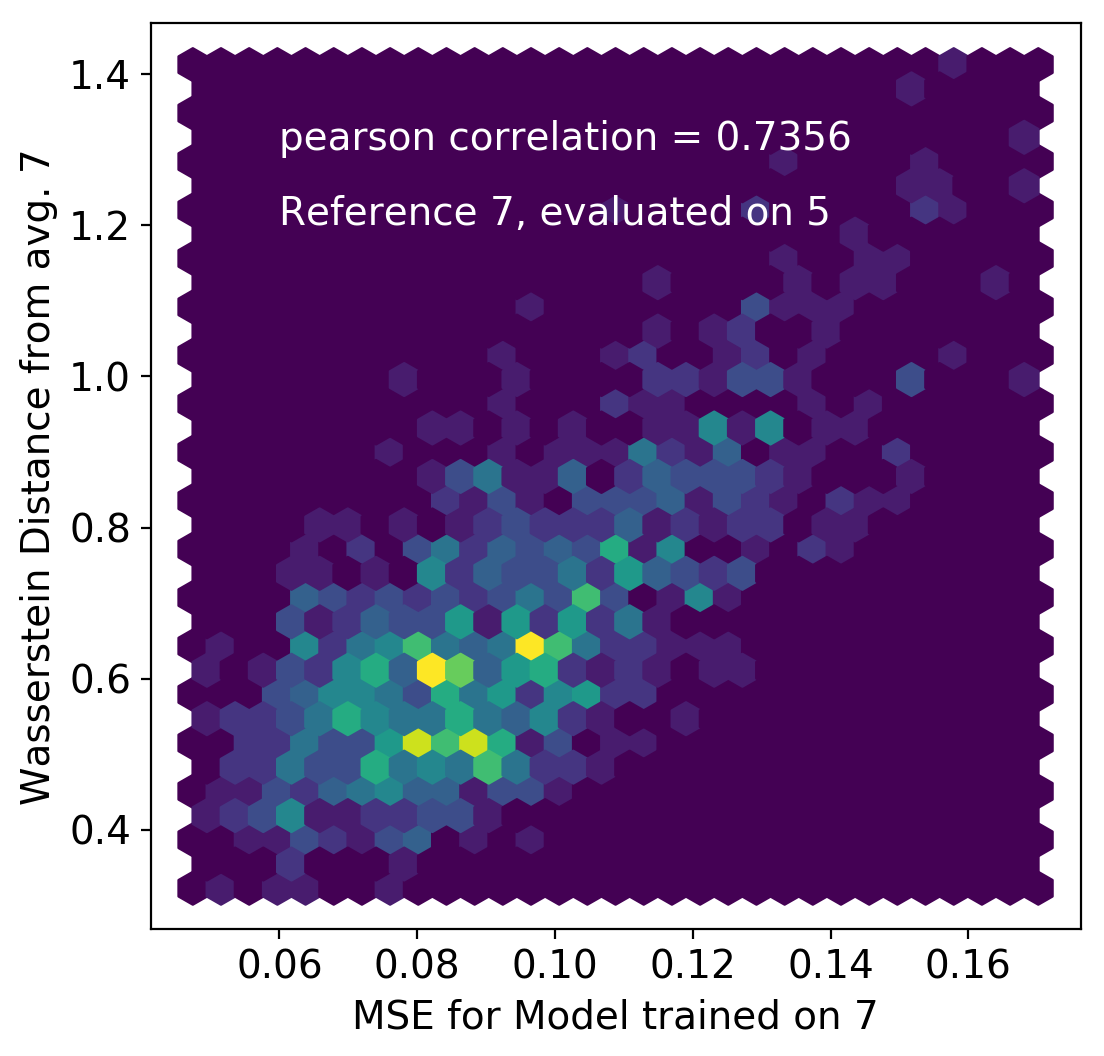

In [177]:
plt.hexbin(loss_list,wasserstein_list,gridsize=30)
plt.xlabel('MSE for Model trained on 7')
plt.ylabel('Wasserstein Distance from avg. 7')
plt.text(0.06,1.3,f'pearson correlation = {pearsonr_test[0]:.4f}',color='white')
plt.text(0.06,1.2,f'Reference 7, evaluated on 5',color='white')

In [91]:
mean_norm_image

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

In [108]:
from geomloss import SamplesLoss

loss = SamplesLoss(loss="sinkhorn", p=2, blur=.00001)

In [25]:
import ot
import ot.plot

In [26]:
testdataset = torchvision.datasets.MNIST('./MNIST_DATA',
                   transform=torchvision.transforms.ToTensor(),
                   train=False,
                   download=False)

In [27]:
test_loader = torch.utils.data.DataLoader(
            testdataset,
            batch_size=1,
            shuffle=False)

In [28]:
import time

In [29]:
for i, (x,y) in enumerate(test_loader):
    
    start = time.time()
    norm = x/255.
    M = ot.dist(norm.view(28,28), mean_norm_image, metric='euclidean')
    end = time.time()
    print(end-start)
    print(M[:1])

8.511543273925781e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
7.224082946777344e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
7.081031799316406e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.650520324707031e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.435943603515625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

0.0015125274658203125
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.0002613067626953125
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.4836273193359375e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

5.507469177246094e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.698204040527344e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.412101745605469e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


5.3882598876953125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
6.413459777832031e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.817413330078125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

0.0015842914581298828
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.00010776519775390625
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.555152893066406e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

0.0015497207641601562
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.0003018379211425781
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.53131103515625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

5.626678466796875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.745887756347656e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.817413330078125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
6.0558319091796875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.745887756347656e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

0.0015897750854492188
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.0002837181091308594
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.53131103515625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

6.866455078125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
7.62939453125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.602836608886719e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.350

5.364418029785156e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
7.605552673339844e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.626678466796875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


5.435943603515625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.91278076171875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.602836608886719e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

5.7697296142578125e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.841255187988281e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.555152893066406e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5.412101745605469e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.507469177246094e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.340576171875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8

0.0016222000122070312
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.00010704994201660156
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.555152893066406e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

0.0015406608581542969
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
0.0002186298370361328
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.602836608886719e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.507469177246094e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.5789947509765625e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.35052395e-06 3.00787392e-04 3.65073685e-03 1.47620681e-02
  2.56705689e-02 2.78363076e-02 2.28323641e-02 1.75542200e-02
  1.50141646e-02 1.42641857e-02 1.44260260e-02 1.48194359e-02
  1.49214248e-02 1.45679524e-02 1.38867605e-02 1.31314719e-02
  1.25083185e-02 1.19654776e-02 1.15089887e-02 1.10091557e-02
  1.02125910e-02 8.43720816e-03 4.62715214e-03 5.94130848e-04]]
5.91278076171875e-05
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00

In [55]:
def get_loss_and_wasserstein(digit):
    print("begin")
    testdataset = torchvision.datasets.MNIST('./MNIST_DATA',
                   transform=torchvision.transforms.ToTensor(),
                   train=False,
                   download=False)

    indices = testdataset.targets == digit

    testdataset.data, testdataset.targets = testdataset.data[indices], testdataset.targets[indices]

    test_loader = torch.utils.data.DataLoader(
            testdataset,
            batch_size=1000,
            shuffle=False)

    loss_list = np.array([])
    for i, (x,y) in enumerate(test_loader):

        VAE_loss = torch.mean((vae(x.to(device)).view(-1,784)- x.to(device).view(-1,784))**2,dim=1).data.cpu().numpy()
        print(VAE_loss.shape)
        loss_list = np.append(loss_list,VAE_loss)

    test_loader = torch.utils.data.DataLoader(
            testdataset,
            batch_size=1,
            shuffle=False)

    #wasserstein_list = np.array([])
    #wasserstein_scipy_list = np.array([])
    wasserstein_ot_list = np.array([])
    M = ot.dist(x[0].view(28,28), mean_norm_image, metric='euclidean')
    for i, (x,y) in enumerate(test_loader):
        print(i)
        norm_image = x/x.sum()
        print(norm_image.view(28,28).numpy().shape)
        print(mean_norm_image.shape)
        #M = ot.dist(norm_image.view(28,28), mean_norm_image, metric='euclidean')
        wasserstein_ot_list = np.append(wasserstein_ot_list, ot.lp.emd2(norm_image.view(28,28).numpy(),mean_norm_image, M, processes = 2) )
        #wasserstein_list = np.append(wasserstein_list,loss(norm_image.view(28,28).to(device),mean_norm_image.to(device)).data.cpu().numpy())
        #wasserstein_scipy_list = np.append(wasserstein_scipy_list,wasserstein_distance(x.view(784).data.cpu().numpy(),mean_image.view(784).data.cpu().numpy()))
        
    #return loss_list, wasserstein_list, wasserstein_scipy_list
    return loss_list, wasserstein_ot_list

In [ ]:
five_loss, five_ot = get_loss_and_wasserstein(5)

begin
(892,)
0
(28, 28)
(28, 28)


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/ot/utils.py", line 237, in fun
    q_out.put((i, f(x)))
  File "/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/ot/utils.py", line 237, in fun
    q_out.put((i, f(x)))
  File "/data/t3home000/sp

In [110]:
five_loss, five_wass, five_scipy = get_loss_and_wasserstein(5)

(892,)
0
tensor(1.0000)
1
tensor(1.)
2
tensor(1.0000)
3
tensor(1.)
4
tensor(1.0000)
5
tensor(1.0000)
6
tensor(1.)
7
tensor(1.0000)
8
tensor(1.)
9
tensor(1.0000)
10
tensor(1.0000)
11
tensor(1.)
12
tensor(1.)
13
tensor(1.0000)
14
tensor(1.0000)
15
tensor(1.0000)
16
tensor(1.)
17
tensor(1.)
18
tensor(1.)
19
tensor(1.)
20
tensor(1.0000)
21
tensor(1.)
22
tensor(1.0000)
23
tensor(1.0000)
24
tensor(1.0000)
25
tensor(1.0000)
26
tensor(1.)
27
tensor(1.0000)
28
tensor(1.)
29
tensor(1.)
30
tensor(1.)
31
tensor(1.0000)
32
tensor(1.0000)
33
tensor(1.0000)
34
tensor(1.)
35
tensor(1.)
36
tensor(1.)
37
tensor(1.0000)
38
tensor(1.)
39
tensor(1.0000)
40
tensor(1.0000)
41
tensor(1.0000)
42
tensor(1.)
43
tensor(1.)
44
tensor(1.)
45
tensor(1.)
46
tensor(1.0000)
47
tensor(1.)
48
tensor(1.)
49
tensor(1.)
50
tensor(1.)
51
tensor(1.)
52
tensor(1.0000)
53
tensor(1.)
54
tensor(1.0000)
55
tensor(1.0000)
56
tensor(1.)
57
tensor(1.0000)
58
tensor(1.)
59
tensor(1.)
60
tensor(1.0000)
61
tensor(1.0000)
62
tensor(1.)
6

501
tensor(1.0000)
502
tensor(1.)
503
tensor(1.0000)
504
tensor(1.)
505
tensor(1.)
506
tensor(1.0000)
507
tensor(1.0000)
508
tensor(1.0000)
509
tensor(1.0000)
510
tensor(1.0000)
511
tensor(1.0000)
512
tensor(1.0000)
513
tensor(1.)
514
tensor(1.0000)
515
tensor(1.0000)
516
tensor(1.)
517
tensor(1.)
518
tensor(1.0000)
519
tensor(1.0000)
520
tensor(1.0000)
521
tensor(1.)
522
tensor(1.)
523
tensor(1.0000)
524
tensor(1.0000)
525
tensor(1.0000)
526
tensor(1.0000)
527
tensor(1.0000)
528
tensor(1.0000)
529
tensor(1.)
530
tensor(1.)
531
tensor(1.)
532
tensor(1.)
533
tensor(1.0000)
534
tensor(1.)
535
tensor(1.0000)
536
tensor(1.)
537
tensor(1.)
538
tensor(1.)
539
tensor(1.)
540
tensor(1.)
541
tensor(1.)
542
tensor(1.0000)
543
tensor(1.)
544
tensor(1.)
545
tensor(1.0000)
546
tensor(1.)
547
tensor(1.0000)
548
tensor(1.)
549
tensor(1.)
550
tensor(1.0000)
551
tensor(1.)
552
tensor(1.)
553
tensor(1.)
554
tensor(1.)
555
tensor(1.)
556
tensor(1.0000)
557
tensor(1.)
558
tensor(1.0000)
559
tensor(1.0000)

In [111]:
seven_loss, seven_wass, seven_scipy = get_loss_and_wasserstein(7);

(1000,)
(28,)
0
tensor(1.)
1
tensor(1.0000)
2
tensor(1.0000)
3
tensor(1.)
4
tensor(1.)
5
tensor(1.0000)
6
tensor(1.)
7
tensor(1.)
8
tensor(1.)
9
tensor(1.0000)
10
tensor(1.0000)
11
tensor(1.)
12
tensor(1.)
13
tensor(1.0000)
14
tensor(1.)
15
tensor(1.0000)
16
tensor(1.0000)
17
tensor(1.0000)
18
tensor(1.0000)
19
tensor(1.)
20
tensor(1.0000)
21
tensor(1.0000)
22
tensor(1.)
23
tensor(1.)
24
tensor(1.)
25
tensor(1.)
26
tensor(1.0000)
27
tensor(1.)
28
tensor(1.0000)
29
tensor(1.0000)
30
tensor(1.)
31
tensor(1.)
32
tensor(1.)
33
tensor(1.0000)
34
tensor(1.0000)
35
tensor(1.)
36
tensor(1.)
37
tensor(1.)
38
tensor(1.)
39
tensor(1.)
40
tensor(1.)
41
tensor(1.)
42
tensor(1.)
43
tensor(1.)
44
tensor(1.)
45
tensor(1.)
46
tensor(1.0000)
47
tensor(1.0000)
48
tensor(1.0000)
49
tensor(1.)
50
tensor(1.0000)
51
tensor(1.)
52
tensor(1.)
53
tensor(1.0000)
54
tensor(1.)
55
tensor(1.0000)
56
tensor(1.0000)
57
tensor(1.)
58
tensor(1.)
59
tensor(1.0000)
60
tensor(1.0000)
61
tensor(1.0000)
62
tensor(1.0000)
63

501
tensor(1.)
502
tensor(1.)
503
tensor(1.0000)
504
tensor(1.0000)
505
tensor(1.0000)
506
tensor(1.)
507
tensor(1.0000)
508
tensor(1.)
509
tensor(1.)
510
tensor(1.)
511
tensor(1.)
512
tensor(1.0000)
513
tensor(1.0000)
514
tensor(1.0000)
515
tensor(1.0000)
516
tensor(1.)
517
tensor(1.)
518
tensor(1.)
519
tensor(1.)
520
tensor(1.0000)
521
tensor(1.)
522
tensor(1.)
523
tensor(1.)
524
tensor(1.)
525
tensor(1.0000)
526
tensor(1.)
527
tensor(1.)
528
tensor(1.)
529
tensor(1.)
530
tensor(1.)
531
tensor(1.0000)
532
tensor(1.0000)
533
tensor(1.)
534
tensor(1.0000)
535
tensor(1.)
536
tensor(1.)
537
tensor(1.)
538
tensor(1.)
539
tensor(1.0000)
540
tensor(1.0000)
541
tensor(1.)
542
tensor(1.)
543
tensor(1.0000)
544
tensor(1.0000)
545
tensor(1.0000)
546
tensor(1.0000)
547
tensor(1.)
548
tensor(1.0000)
549
tensor(1.)
550
tensor(1.)
551
tensor(1.)
552
tensor(1.)
553
tensor(1.0000)
554
tensor(1.0000)
555
tensor(1.)
556
tensor(1.0000)
557
tensor(1.)
558
tensor(1.0000)
559
tensor(1.)
560
tensor(1.)
561


998
tensor(1.)
999
tensor(1.)
1000
tensor(1.0000)
1001
tensor(1.0000)
1002
tensor(1.)
1003
tensor(1.)
1004
tensor(1.)
1005
tensor(1.0000)
1006
tensor(1.)
1007
tensor(1.0000)
1008
tensor(1.)
1009
tensor(1.)
1010
tensor(1.)
1011
tensor(1.0000)
1012
tensor(1.)
1013
tensor(1.)
1014
tensor(1.0000)
1015
tensor(1.)
1016
tensor(1.)
1017
tensor(1.0000)
1018
tensor(1.)
1019
tensor(1.)
1020
tensor(1.0000)
1021
tensor(1.0000)
1022
tensor(1.)
1023
tensor(1.0000)
1024
tensor(1.)
1025
tensor(1.0000)
1026
tensor(1.0000)
1027
tensor(1.0000)


In [112]:
nine_loss, nine_wass, nine_scipy = get_loss_and_wasserstein(9)

(1000,)
(9,)
0
tensor(1.)
1
tensor(1.)
2
tensor(1.0000)
3
tensor(1.)
4
tensor(1.)
5
tensor(1.)
6
tensor(1.0000)
7
tensor(1.)
8
tensor(1.)
9
tensor(1.)
10
tensor(1.0000)
11
tensor(1.)
12
tensor(1.0000)
13
tensor(1.)
14
tensor(1.0000)
15
tensor(1.0000)
16
tensor(1.)
17
tensor(1.0000)
18
tensor(1.)
19
tensor(1.)
20
tensor(1.)
21
tensor(1.0000)
22
tensor(1.0000)
23
tensor(1.)
24
tensor(1.0000)
25
tensor(1.)
26
tensor(1.0000)
27
tensor(1.)
28
tensor(1.0000)
29
tensor(1.0000)
30
tensor(1.0000)
31
tensor(1.0000)
32
tensor(1.)
33
tensor(1.)
34
tensor(1.)
35
tensor(1.0000)
36
tensor(1.)
37
tensor(1.)
38
tensor(1.)
39
tensor(1.0000)
40
tensor(1.0000)
41
tensor(1.)
42
tensor(1.)
43
tensor(1.)
44
tensor(1.)
45
tensor(1.)
46
tensor(1.)
47
tensor(1.)
48
tensor(1.)
49
tensor(1.0000)
50
tensor(1.)
51
tensor(1.)
52
tensor(1.)
53
tensor(1.)
54
tensor(1.0000)
55
tensor(1.)
56
tensor(1.0000)
57
tensor(1.)
58
tensor(1.)
59
tensor(1.)
60
tensor(1.0000)
61
tensor(1.)
62
tensor(1.)
63
tensor(1.0000)
64
tensor

504
tensor(1.)
505
tensor(1.)
506
tensor(1.0000)
507
tensor(1.0000)
508
tensor(1.0000)
509
tensor(1.)
510
tensor(1.0000)
511
tensor(1.0000)
512
tensor(1.)
513
tensor(1.)
514
tensor(1.)
515
tensor(1.)
516
tensor(1.0000)
517
tensor(1.)
518
tensor(1.)
519
tensor(1.0000)
520
tensor(1.0000)
521
tensor(1.0000)
522
tensor(1.0000)
523
tensor(1.)
524
tensor(1.0000)
525
tensor(1.0000)
526
tensor(1.)
527
tensor(1.)
528
tensor(1.)
529
tensor(1.0000)
530
tensor(1.)
531
tensor(1.)
532
tensor(1.)
533
tensor(1.0000)
534
tensor(1.)
535
tensor(1.)
536
tensor(1.)
537
tensor(1.0000)
538
tensor(1.)
539
tensor(1.)
540
tensor(1.)
541
tensor(1.0000)
542
tensor(1.)
543
tensor(1.)
544
tensor(1.0000)
545
tensor(1.0000)
546
tensor(1.)
547
tensor(1.0000)
548
tensor(1.0000)
549
tensor(1.)
550
tensor(1.)
551
tensor(1.0000)
552
tensor(1.)
553
tensor(1.0000)
554
tensor(1.0000)
555
tensor(1.)
556
tensor(1.)
557
tensor(1.)
558
tensor(1.0000)
559
tensor(1.)
560
tensor(1.)
561
tensor(1.0000)
562
tensor(1.)
563
tensor(1.00

1008
tensor(1.0000)


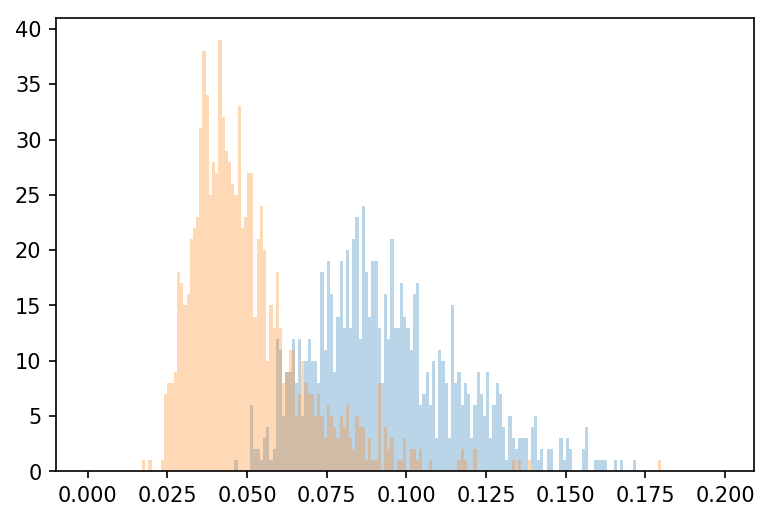

In [113]:
plt.hist(five_loss,bins=np.arange(0,0.2,0.001),alpha=0.3);
plt.hist(nine_loss,bins=np.arange(0,0.2,0.001),alpha=0.3);

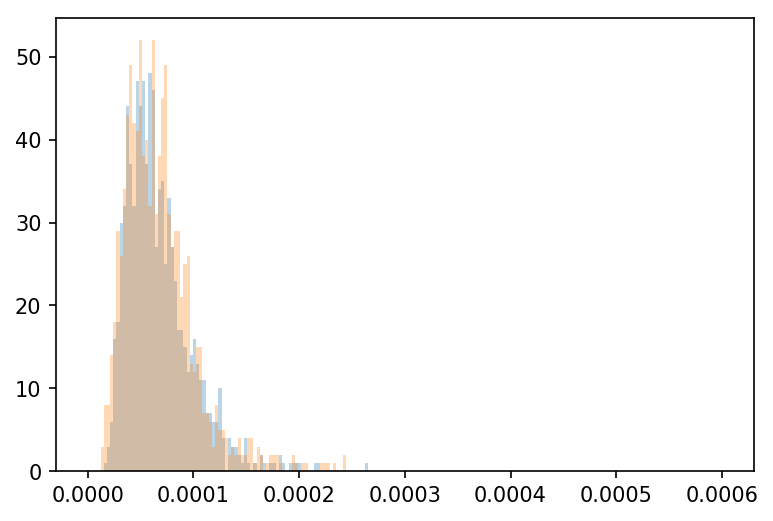

In [119]:
plt.hist(five_wass,bins=np.linspace(0,0.0006,200),alpha=0.3);
plt.hist(seven_wass,bins=np.linspace(0,0.0006,200),alpha=0.3);

In [229]:
def get_tpr_fpr(sigloss,bkgloss,range_low, range_high, aetype='bkg'):
    bins = np.linspace(range_low,range_high,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr  

In [230]:
loss_tpr, loss_fpr = get_tpr_fpr(five_loss, seven_loss, 0, 0.2)

In [231]:
wass_tpr, wass_fpr = get_tpr_fpr(five_wass, seven_wass, 0.2, 1.8)

Text(0, 0.5, 'tpr')

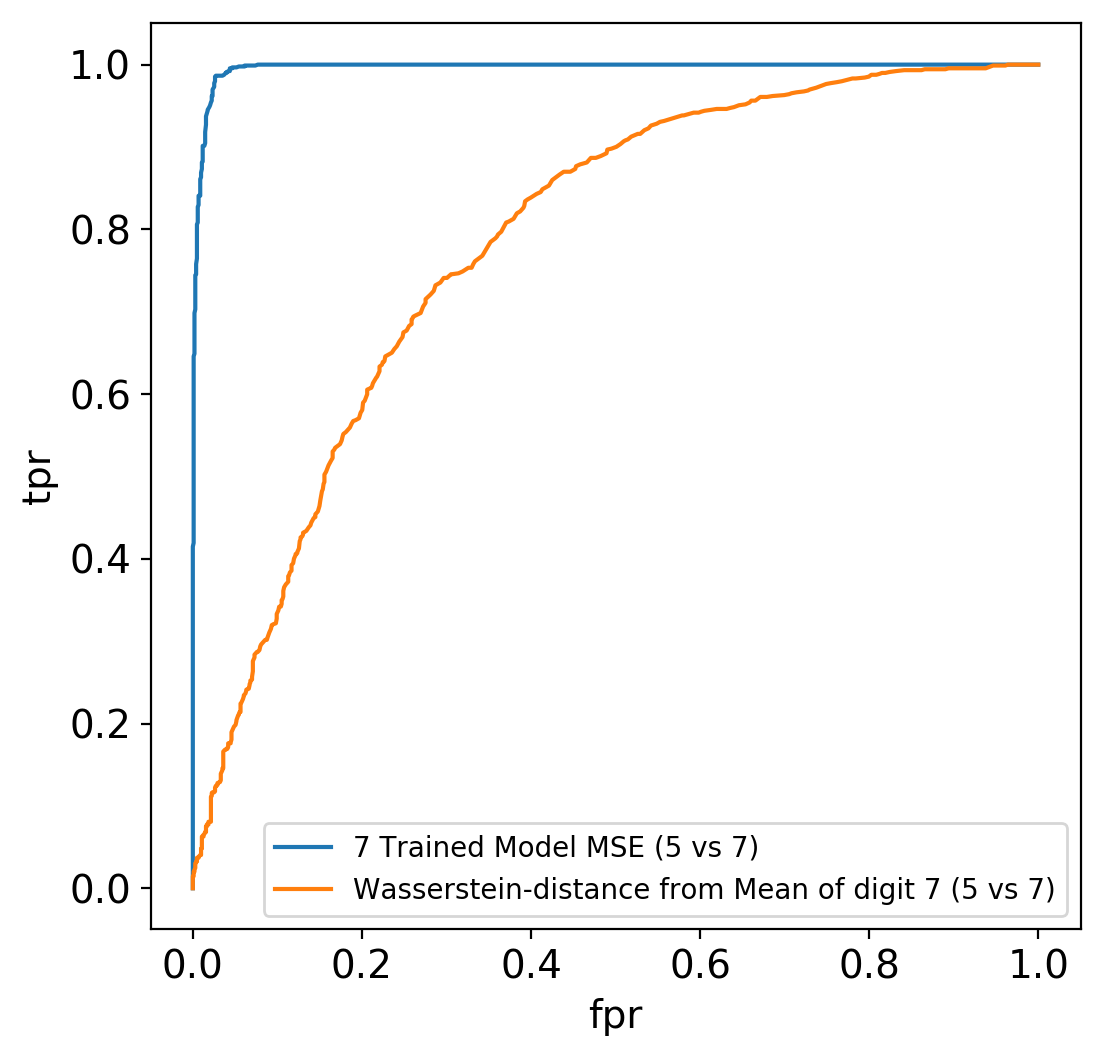

In [232]:
plt.plot(loss_fpr, loss_tpr, label='7 Trained Model MSE (5 vs 7)')
plt.plot(wass_fpr, wass_tpr, label='Wasserstein-distance from Mean of digit 7 (5 vs 7)')
plt.legend(loc=4,fontsize=10)
plt.xlabel('fpr')
plt.ylabel('tpr')